# ML4: Support Vector Machine
- Name: Gelli Mae Gloria
- Date: January 14, 2021
- Student Number: 2015-06435

### Preliminaries
Import all important packages from Python: 
* **Pandas**: Reading and loading the file; make dataframes 
* **Numpy**: For multidimensional array and operations on arrays
* **Matplotlib/Seaborn**: For our visualizations
* **Random**: For the initialization of the random number generator for the weights

In [1]:
import cvxopt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import seed
from cvxopt import matrix, solvers


In [206]:
# Create dataframe for each fruit class

mango = pd.read_excel('ML1_dataset(1).xlsx', sheet_name = 'Class 1 - Mango')
orange = pd.read_excel('ML1_dataset(1).xlsx', sheet_name = 'Class 2 - Orange')
banana = pd.read_excel('ML1_dataset(1).xlsx', sheet_name = 'Class 3 - Banana')
mango = pd.DataFrame(mango)
orange = pd.DataFrame(orange)
banana = pd.DataFrame(banana)
orange.head()

,Image,R,G,B,Hue,StDev,Median,Skew,AR,Round
0,1,236.764,200.613,153.233,34.032874,33.247,138,0.660,1.025,0.976
1,2,245.911,266.276,179.424,78.378029,37.526,156,0.758,1.010,0.990
2,3,116.534,109.282,18.273,55.571793,28.342,115,0.587,1.681,0.595
3,4,220.972,215.616,191.501,49.095721,32.131,147,0.943,1.130,0.885
4,5,249.121,206.316,122.162,39.770635,20.441,151,1.635,1.037,0.965


In [207]:
def hue(R,G,B):
    vals = [R, G, B]
    max_vals = max(vals)
    min_vals = min(vals)
    
    if max_vals == R:
        hue = 60 * (G-B)/(max_vals - min_vals)
    elif max_vals == G:
        hue = 60 * (2+(B-R)/(max_vals - min_vals))
    else:
        hue = 60 * (4+(R-G)/(max_vals - min_vals))
    
    return hue

## Mango vs Orange

In [280]:
mango['Hue'] = mango.apply(lambda x: hue(x['R'], x['G'], x['B']), axis = 1)
mango["Class"] = 1
mango["Class_name"] = 'Mango'
orange['Hue'] = orange.apply(lambda x: hue(x['R'], x['G'], x['B']), axis = 1)
orange["Class_name"] = 'Orange'
orange["Class"] = -1

In [281]:
data = pd.concat([mango, orange], ignore_index = True, sort = False)
data = data.drop(columns = ['Image', 'R', 'G', 'B', 'Skew'])
data['Hue_norm'] = data['Hue']/max(data['Hue'])
data['x_0'] = 1.0

test = pd.concat([mango.iloc[14:], orange.iloc[14:]], ignore_index = True, sort = False)
test = test.drop(columns = ['Image', 'R', 'G', 'B', 'Skew'])
test['Hue_norm'] = test['Hue']/max(test['Hue'])
test['x_0'] = 1.0

In [282]:
X = np.array(data[['Hue_norm','Round']])
Z = np.array(data[['Class']])

X1 = np.array(test[['Hue_norm','Round']])
Z1 = np.array(test[['Class']])

In [283]:
h = np.matmul(Z,Z.T) * np.matmul(X,X.T)
H = cvxopt.matrix(h, tc='d')
A = cvxopt.matrix(-np.identity(h.shape[0]),tc='d')
B = (cvxopt.matrix(Z, tc = 'd')).T

s = cvxopt.matrix(np.eye(h.shape[0])*0.005, tc= 'd')

In [285]:
f = cvxopt.matrix(-np.ones((h.shape[0],1)), tc = 'd')
a = cvxopt.matrix(np.zeros((h.shape[0],1)), tc='d')
# b = cvxopt.matrix(np.zeros((h.shape[0],1)), tc = 'd')
b = cvxopt.matrix(float(0), tc = 'd')

In [286]:
lambd = solvers.qp(H+s, f, A, a, B, b)   # x, y ,s, z
alpha = np.array(lambd['x'])
alpha.shape

     pcost       dcost       gap    pres   dres
 0: -2.9131e+01 -7.5361e+01  5e+01  7e-16  2e+00
 1: -5.5732e+01 -7.4368e+01  2e+01  2e-15  1e+00
 2: -1.9206e+02 -2.2924e+02  4e+01  9e-15  1e+00
 3: -1.3369e+03 -1.5348e+03  2e+02  8e-14  7e-01
 4: -2.2445e+03 -2.8862e+03  6e+02  6e-13  5e-02
 5: -2.2611e+03 -2.2874e+03  3e+01  5e-13  2e-03
 6: -2.2613e+03 -2.2617e+03  4e-01  2e-13  2e-05
 7: -2.2614e+03 -2.2614e+03  5e-03  3e-13  2e-07
 8: -2.2614e+03 -2.2614e+03  5e-05  3e-13  2e-09
Optimal solution found.


(41, 1)

In [291]:
# Finding weights
first = alpha*Z
weights = np.dot(first.T, X).T
w0 = np.add((float(1/Z[0])),float(-np.dot(weights.T,X[0])))
w0, weights.shape

(2.6858661963651462, (2, 1))

In [292]:
# Prediction and margin
ans = np.array(w0+weights[0]*X[:,0]+weights[1]*X[:,1])

pred_1 = (ans>=0)
pred_1 = np.array(matrix(pred_1.astype(float)))
pred_2 = (ans<0)
pred_2 = -np.array(matrix(pred_2.astype(float)))

a = (Z==pred_1).astype(float)
c = (Z==pred_2).astype(float)

accuracy = (np.sum(a)+np.sum(c))/len(pred_1) * 100
accuracy
margin = 2/np.linalg.norm(weights)
margin

0.45613916743017835

### Visualizations

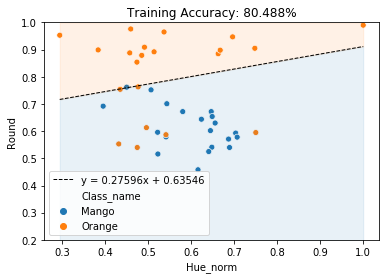

In [216]:
b1 = -w0/weights[1]
m1 = -(weights[0]/weights[1])
f_x_test = b1 + np.dot(X[:,0].reshape(X.shape[0],1),m1) # Decision line equation

xd = np.array([min(X[:,0]), max(X[:,0])])
yd = m1*xd + b1

sns.scatterplot(data=data, x='Hue_norm', y='Round', hue='Class_name')
plt.plot(xd,yd,'--k', lw=1, label = 'y = %0.5fx + %0.5f'%(m1, b1))
plt.fill_between(xd, yd, 0, color='tab:blue', alpha=0.1)
plt.fill_between(xd, yd, 1, color='tab:orange', alpha=0.1)
plt.title('Training Accuracy: %0.3f' %(accuracy)+'%')
plt.legend()
plt.ylim(0.2, 1)

plt.savefig('ML4_SVM_mvo.png')

## Second SEEEET (Orange vs Banana)

In [265]:
orange['Hue'] = orange.apply(lambda x: hue(x['R'], x['G'], x['B']), axis = 1)
orange["Class_name"] = 'Orange'
orange["Class"] = -1
banana['Hue'] = banana.apply(lambda x: hue(x['R'], x['G'], x['B']), axis = 1)
banana["Class_name"] = 'Banana'
banana["Class"] = 1

mango.head()

,Image,R,G,B,StDev,Median,AR,Skew,Round,Hue,Class,Class_name
0,1,215,210,177,35.793,183,1.688,-0.679,0.593,52.105263,1,Mango
1,2,248,190,73,14.205,175,1.727,-0.416,0.579,40.114286,1,Mango
2,3,233,151,14,29.574,131,1.330,-0.385,0.752,37.534247,1,Mango
3,4,246,225,81,20.652,158,1.729,-0.553,0.578,52.363636,1,Mango
4,5,220,155,93,30.002,110,1.446,0.831,0.692,29.291339,1,Mango


In [266]:
data = pd.concat([banana, orange], ignore_index = True, sort = False)
data = data.drop(columns = ['Image', 'R', 'G', 'B', 'Skew'])
data['Hue_norm'] = data['Hue']/max(data['Hue'])
data['x_0'] = 1.0

In [267]:
X = np.array(data[['Hue_norm','Round']])
Z = np.array(data[['Class']])

In [268]:
h = np.matmul(Z,Z.T) * np.matmul(X,X.T)
H = cvxopt.matrix(h, tc='d')#
A = cvxopt.matrix(-np.identity(h.shape[0]),tc='d')
B = cvxopt.matrix(Z, tc = 'd').T

s = cvxopt.matrix(np.eye(h.shape[0])*0.005, tc= 'd')
f = cvxopt.matrix(-np.ones((h.shape[0],1)), tc = 'd')
a = cvxopt.matrix(np.zeros((h.shape[0],1)), tc='d')
# b = cvxopt.matrix(np.zeros((h.shape[0],1)), tc = 'd')
b = cvxopt.matrix(float(0), tc = 'd')

In [269]:
lambd = solvers.qp(H+s, f, A, a, B, b)   # x, y ,s, z
alpha = np.array(lambd['x'])

     pcost       dcost       gap    pres   dres
 0: -2.4168e+01 -6.6541e+01  4e+01  3e-15  2e+00
 1: -4.0784e+01 -6.3045e+01  2e+01  1e-15  1e+00
 2: -1.8994e+02 -2.3069e+02  4e+01  1e-14  1e+00
 3: -3.0933e+02 -3.7131e+02  6e+01  1e-14  1e+00
 4: -6.9105e+02 -8.4915e+02  2e+02  3e-14  9e-01
 5: -1.3147e+03 -1.6594e+03  3e+02  1e-13  6e-01
 6: -1.5278e+03 -1.6363e+03  1e+02  1e-13  8e-02
 7: -1.5314e+03 -1.5338e+03  2e+00  2e-13  7e-04
 8: -1.5321e+03 -1.5321e+03  4e-02  3e-13  1e-05
 9: -1.5321e+03 -1.5321e+03  4e-04  4e-13  1e-07
10: -1.5321e+03 -1.5321e+03  4e-06  1e-13  1e-09
Optimal solution found.


In [270]:
# Finding weights
first = alpha*Z
weights = np.dot(first.T, X).T
w0 = np.add((float(1/Z[0])),float(-np.dot(weights.T,X[0])))
w0

1.3881243082660206

In [272]:
ans = np.array(w0+weights[0]*X[:,0]+weights[1]*X[:,1])

pred_1 = (ans>=0)
pred_1 = np.array(matrix(pred_1.astype(float)))
pred_2 = (ans<0)
pred_2 = -np.array(matrix(pred_2.astype(float)))

a = (Z==pred_1).astype(float)
c = (Z==pred_2).astype(float)

accuracy = (np.sum(a)+np.sum(c))/len(pred_1) * 100
accuracy
margin = 2/np.linalg.norm(weights)
margin

0.29643863756107797

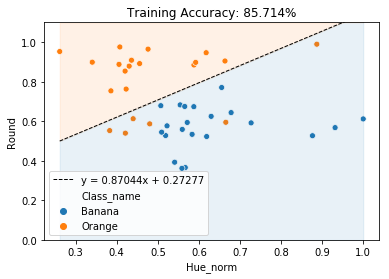

In [225]:
b2 = -w0/weights[1]
m2 = -(weights[0]/weights[1])
f_x_test = b2 + np.dot(X[:,0].reshape(X.shape[0],1),m2) # Decision line equation

xd = np.array([min(X[:,0]), max(X[:,0])])
yd = m2*xd + b2

sns.scatterplot(data=data, x='Hue_norm', y='Round', hue='Class_name')
plt.plot(xd,yd,'--k', lw=1, label = 'y = %0.5fx + %0.5f'%(m2, b2))
plt.fill_between(xd, yd, 0, color='tab:blue', alpha=0.1)
plt.fill_between(xd, yd, 1.1, color='tab:orange', alpha=0.1)
plt.title('Training Accuracy: %0.3f' %(accuracy) + '%')
plt.legend()
plt.ylim(0,1.1)

plt.savefig('ML4_SVM_bvso.png')

## Third Seeeet (Mango vs Banana)

In [273]:
mango['Hue'] = mango.apply(lambda x: hue(x['R'], x['G'], x['B']), axis = 1)
mango["Class"] = 1
mango["Class_name"] = 'Mango'
banana['Hue'] = banana.apply(lambda x: hue(x['R'], x['G'], x['B']), axis = 1)
banana["Class_name"] = 'Banana'
banana["Class"] = -1

mango.head()

,Image,R,G,B,StDev,Median,AR,Skew,Round,Hue,Class,Class_name
0,1,215,210,177,35.793,183,1.688,-0.679,0.593,52.105263,1,Mango
1,2,248,190,73,14.205,175,1.727,-0.416,0.579,40.114286,1,Mango
2,3,233,151,14,29.574,131,1.330,-0.385,0.752,37.534247,1,Mango
3,4,246,225,81,20.652,158,1.729,-0.553,0.578,52.363636,1,Mango
4,5,220,155,93,30.002,110,1.446,0.831,0.692,29.291339,1,Mango


In [274]:
data = pd.concat([mango, banana], ignore_index = True, sort = False)
data = data.drop(columns = ['Image', 'R', 'G', 'B', 'Skew'])
data['Hue_norm'] = data['Hue']/max(data['Hue'])
data['x_0'] = 1.0

In [275]:
X = np.array(data[['Hue_norm','Round']])
Z = np.array(data[['Class']])

In [276]:
h = np.matmul(Z,Z.T) * np.matmul(X,X.T)
H = cvxopt.matrix(h, tc='d')#
A = cvxopt.matrix(-np.identity(h.shape[0]),tc='d')
B = cvxopt.matrix(Z, tc = 'd').T

s = cvxopt.matrix(np.eye(h.shape[0])*0.005, tc= 'd')
f = cvxopt.matrix(-np.ones((h.shape[0],1)), tc = 'd')
a = cvxopt.matrix(np.zeros((h.shape[0],1)), tc='d')
# b = cvxopt.matrix(np.zeros((h.shape[0],1)), tc = 'd')
b = cvxopt.matrix(float(0), tc = 'd')

In [277]:
lambd = solvers.qp(H+s, f, A, a, B, b)   # x, y ,s, z
alpha = np.array(lambd['x'])

     pcost       dcost       gap    pres   dres
 0: -3.6713e+01 -8.0731e+01  4e+01  1e-15  2e+00
 1: -7.6551e+01 -9.1333e+01  1e+01  5e-15  1e+00
 2: -3.0666e+02 -3.5053e+02  4e+01  8e-15  1e+00
 3: -4.2200e+02 -4.8333e+02  6e+01  2e-14  1e+00
 4: -6.8933e+02 -7.9927e+02  1e+02  6e-14  1e+00
 5: -1.3483e+03 -1.6183e+03  3e+02  1e-13  9e-01
 6: -2.5620e+03 -3.2151e+03  7e+02  2e-13  6e-01
 7: -3.2525e+03 -3.5751e+03  3e+02  4e-13  1e-01
 8: -3.2624e+03 -3.2680e+03  6e+00  6e-13  2e-03
 9: -3.2624e+03 -3.2625e+03  8e-02  8e-13  2e-05
10: -3.2624e+03 -3.2624e+03  2e-03  2e-13  2e-07
11: -3.2624e+03 -3.2624e+03  5e-05  3e-13  2e-09
Optimal solution found.


In [278]:
# Finding weights
first = alpha*Z
weights = np.dot(first.T, X).T
w0 = np.add((float(1/Z[0])),float(-np.dot(weights.T,X[0])))
w0

2.7925100314355156

In [279]:
ans = np.array(w0+weights[0]*X[:,0]+weights[1]*X[:,1])

pred_1 = (ans>=0)
pred_1 = np.array(matrix(pred_1.astype(float)))
pred_2 = (ans<0)
pred_2 = -np.array(matrix(pred_2.astype(float)))

a = (Z==pred_1).astype(float)
c = (Z==pred_2).astype(float)

accuracy = (np.sum(a)+np.sum(c))/len(pred_1) * 100
accuracy
margin = 2/np.linalg.norm(weights)
margin

0.4275631728571549

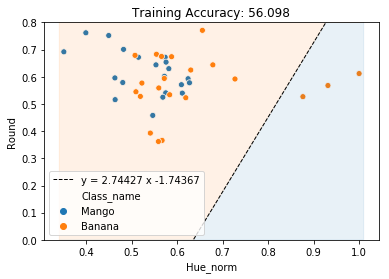

In [233]:
b3 = -w0/weights[1]
m3 = -(weights[0]/weights[1])
f_x_test = b3 + np.dot(X[:,0].reshape(X.shape[0],1),m3) # Decision line equation

xd = np.array([min(X[:,0])-0.01, max(X[:,0])+0.01])
yd = m3*xd + b3

sns.scatterplot(data=data, x='Hue_norm', y='Round', hue='Class_name')
plt.plot(xd,yd,'--k', lw=1, label = 'y = %0.5f x %0.5f' %(m3,b3))
plt.fill_between(xd, yd, 0, color='tab:blue', alpha=0.1)
plt.fill_between(xd, yd, 0.8, color='tab:orange', alpha=0.1)
plt.title('Training Accuracy: %0.3f' %(accuracy))
plt.ylim(0,0.8)
plt.legend(loc='lower left')

plt.savefig('ML4_train_mvsb.png')

### Visualization for the three classes using the decision lines from SVM

In [238]:
# Train set
data1 = pd.concat([mango, orange, banana], ignore_index = True, sort = False) # Locate all 28 
data1['Hue_norm'] = data1['Hue']/max(data1['Hue'])                                            # Normalize hue
data1 = data1.drop(columns = ['Image', 'R', 'G', 'B', 'Skew'])                               # drop all unnecessary columns
data1['x_0'] = 1.0                                                                          # For x_0 from the equation

# Test set
test1 = pd.concat([mango.iloc[11:], orange.iloc[12:], banana.iloc[11:]], ignore_index = True, sort = False)
test1 = test1.drop(columns = ['Image', 'R', 'G', 'B', 'Skew'])
test1['Hue_norm'] = test1['Hue']/max(data['Hue'])
test1['x_0'] = 1.0 

# Train set
X1 = list(data1['Hue_norm'])
X2 = list(data1['Round'])
x = np.array(data1[['x_0','Hue_norm','Round']]) 
Y = np.array(data1[['Class']])

# Test set
X1_test = list(test1['Hue_norm'])
X2_test = list(test1['Round'])
x_test = np.array(test1[['x_0','Hue_norm','Round']])
Y_test = np.array(test1[['Class']])

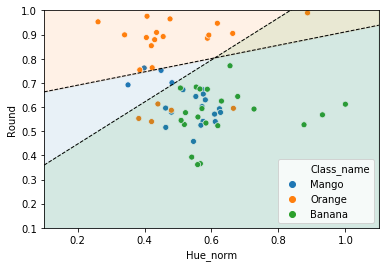

In [240]:
# b = -result[0]/result[2]
# m = -(result[1]/result[2])
# f_x_test = b + np.dot(x_test[:,1].reshape(x_test.shape[0],1),m) # Decision line equation

xd = np.array([0.2-0.1,1.1])
# yd = m*xd + b

sns.scatterplot(data=data1, x='Hue_norm', y='Round', hue='Class_name')
plt.plot(xd,m1*xd + b1,'--k', lw=1)
plt.plot(xd,m2*xd + b2,'--k', lw=1)
# plt.plot(xd,m2*xd + b2,'--k', lw=1)

plt.fill_between(xd, m1*xd + b1, 0.1, color='tab:blue', alpha=0.1)
plt.fill_between(xd, m1*xd + b1, 1.1, color='tab:orange', alpha=0.1)

plt.fill_between(xd, m2*xd + b2, 0, color='tab:green', alpha=0.1)
# plt.fill_between(xd, m1*xd + b1, 1.1, color='tab:orange', alpha=0.1)

# plt.fill_between(xd, m2*xd + b2, 0.3, color='tab:green', alpha=0.1)
# plt.fill_between(xd, m2*xd + b2, 0.75, color='tab:blue', alpha=0.1)
plt.ylim(0.1,1)
plt.xlim(0.1,1.1)
# plt.title('Graph for the Test set: %f ' %(float(scores)) + '%' + 'y = %fx + %f' %(m,b))
plt.legend()
plt.savefig('ML4.png')

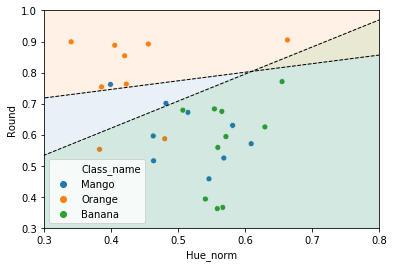

In [236]:
# b = -result[0]/result[2]
# m = -(result[1]/result[2])
# f_x_test = b + np.dot(x_test[:,1].reshape(x_test.shape[0],1),m) # Decision line equation

xd = np.array([min(X[:,1])-0.1, max(X[:,1])+0.1])
# yd = m*xd + b

sns.scatterplot(data=test1, x='Hue_norm', y='Round', hue='Class_name')
plt.plot(xd,m1*xd + b1,'--k', lw=1)
plt.plot(xd,m2*xd + b2,'--k', lw=1)
# plt.plot(xd,m2*xd + b2,'--k', lw=1)

plt.fill_between(xd, m1*xd + b1, 0.2, color='tab:blue', alpha=0.1)
plt.fill_between(xd, m1*xd + b1, 1.1, color='tab:orange', alpha=0.1)

plt.fill_between(xd, m2*xd + b2, 0.3, color='tab:green', alpha=0.1)
# plt.fill_between(xd, m1*xd + b1, 1.1, color='tab:orange', alpha=0.1)

# plt.fill_between(xd, m2*xd + b2, 0.3, color='tab:green', alpha=0.1)
# plt.fill_between(xd, m2*xd + b2, 0.75, color='tab:blue', alpha=0.1)
plt.ylim(0.3,1)
plt.xlim(0.3,0.8)
# plt.title('Graph for the Test set: %f ' %(float(scores)) + '%' + 'y = %fx + %f' %(m,b))

plt.savefig('ML4_test_bvsmvso.png')